In [3]:
import litebird_sim as lbs
import numpy as np
import healpy as hp
from dataclasses import asdict
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [76]:
nside = 64
mission_time_is_sec = 10*24*3600
instrument = "MFT"
channel = "M1-100"
sampling = 1 # this replaces channelinfo.sampling_rate_hz

In [77]:
imo = lbs.Imo()
sim = lbs.Simulation(base_path="./tutorial",
                     start_time=0,
                     duration_s=mission_time_is_sec,
                    )

In [78]:
mft_file = sim.imo.query("/releases/v1.0/satellite/"+instrument+"/instrument_info")
sim.generate_spin2ecl_quaternions(imo_url="/releases/v1.0/satellite/scanning_parameters/")
instrumentinfo = lbs.InstrumentInfo(name=instrument, 
    boresight_rotangle_rad=np.deg2rad(mft_file.metadata["boresight_rotangle_deg"]),
    spin_boresight_angle_rad=np.deg2rad(mft_file.metadata["spin_boresight_angle_deg"]),
    spin_rotangle_rad=np.deg2rad(mft_file.metadata["spin_rotangle_deg"]),
    )
channelinfo = lbs.FreqChannelInfo.from_imo(
    url="/releases/v1.0/satellite/"+instrument+"/"+channel+"/channel_info",
    imo=imo,
    )
hwp_radpsec = mft_file.metadata["hwp_rpm"]*2.0*np.pi/60.0

In [79]:
dets=[]
detquats=[]
#for detname in channelinfo.detector_names[0:20]:
for detname in ('M03_030_QA_100T','M03_030_QA_100B'): #we choose the couple of detector at the MFT boresight
    det=lbs.DetectorInfo.from_imo(
        url="/releases/v1.0/satellite/"+instrument+"/"+channel+"/"+detname+"/detector_info",
        imo=imo,
    )
    det.sampling_rate_hz = sampling
    dets.append(det)
    detquats.append(det.quat)

## Create file with HWP non-ideal parameters for MFT
#### The files 'M/HFT_Mesh_HWP_v2.txt' are given from the simulated HWP profiles at https://wiki.kek.jp/download/attachments/123338913/2019_06_22_MFT_HFT_HWP_GP_to_LB_team.xlsx?version=1&modificationDate=1585750021431&api=v2. We read the MFT one to convert the parameters in the way defined in Giardiello et al.

In [8]:
mft = np.loadtxt('MFT_Mesh_HWP_v2.txt')     

nu = mft[:,0]
h1 = np.sqrt(mft[:,1]) - 1.
h2 = np.sqrt(mft[:,3]) - 1.
beta  = mft[:,5] - 180.
z1 = 0.01*np.ones_like(nu) 
z2 = 0.01*np.ones_like(nu)

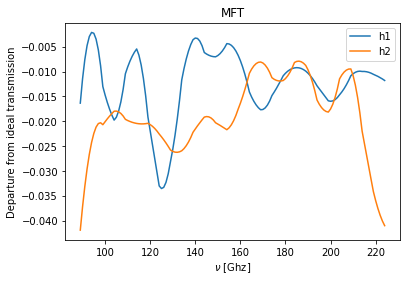

In [7]:
plt.plot(nu,h1,label='h1')
plt.plot(nu,h2,label='h2')
plt.xlabel(r'$\nu$ [Ghz]')
plt.ylabel('Departure from ideal transmission')
plt.title('MFT')
plt.legend()

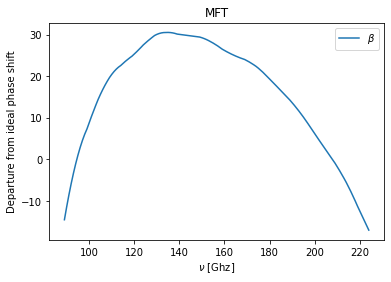

In [8]:
plt.plot(nu,beta,label=r'$\beta$')
plt.xlabel(r'$\nu$ [Ghz]')
plt.ylabel('Departure from ideal phase shift')
plt.title('MFT')
plt.legend()

for the purpose of this exercise, let's focus on the frequencies of the 100 GHz band (89,111)

In [9]:
i_i = np.where(nu == 89)[0][0]
i_f = np.where(nu == 111)[0][0]
Nu=nu[i_i:i_f]
H1=h1[i_i:i_f]
H2=h2[i_i:i_f]
Beta=beta[i_i:i_f]
Z1=z1[i_i:i_f]
Z2=z2[i_i:i_f]

In [10]:
np.savetxt('MFT_100_h_beta_z.txt', np.column_stack((Nu,H1,H2,Beta,Z1,Z2))) 

Our code assumes we also have an header, let's write it:

In [8]:
header = '# nu   h1   h2   beta   z1   z2'
file = open('MFT_100_h_beta_z.txt', 'r')
lines = [line for line in file]
file.close()
file = open('MFT_100_h_beta_z.txt', 'w')
# Rewrite the file: append header if needed, and all lines which previously were there
# excluding any misplaced header lines which were not at row 1
file.write(header + '\n')
file.write(''.join([line for line in lines]))
file.close()

## Fill tod with a band top-hat + wings

In [100]:
obs_w, = sim.create_observations(detectors=dets)

pointings = lbs.scanning.get_pointings(obs_w,
                                       spin2ecliptic_quats=sim.spin2ecliptic_quats,
                                       detector_quats=detquats,
                                       bore2spin_quat=instrumentinfo.bore2spin_quat,
                                      )

if you are using band integration (`integrate_in_band = True` in `hwp_sys.set_parameters`) you don't need to create a map beforehand, the `set_parameters` function of HwpSys will generate one cmb+fg map for each frequency. The following cell is commented because it is not needed when using band integration

In [12]:
#Mbsparams = lbs.MbsParameters(make_cmb =True,
#                              make_fg = False,
#                              gaussian_smooth = True,
#                              bandpass_int = False,
#                              nside = nside,
#                             )

#mbs = lbs.Mbs(simulation=sim,
#              parameters=Mbsparams,
#              channel_list=channelinfo,
#             )
#maps = mbs.run_all()[0][channel]

[2021-12-30 12:21:37,845 INFO MPI#0000] generating and saving cmb simulations
[2021-12-30 12:21:37,863 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2021-12-30 12:21:38,077 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 12:21:38,077 INFO MPI#0000] -> fwhm is 0.000000 arcmin
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from tutorial/cmb/0000/cmb_0000_date_211230.fits
  warnings.warn(f"Access data from {full_path}")
[2021-12-30 12:21:38,960 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2021-12-30 12:21:38,963 INFO MPI#0000] NSIDE = 512
[2021-12-30 12:21:38,963 INFO MPI#0000] ORDERING = RING in fits file
[2021-12-30 12:21:38,964 INFO MPI#0000] INDXSCHM = IMPLICIT


***************** D
***************** D
***************** D


[2021-12-30 12:21:39,725 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2021-12-30 12:21:44,631 INFO MPI#0000] Sigma is 13.079556 arcmin (0.003805 rad) 
[2021-12-30 12:21:44,632 INFO MPI#0000] -> fwhm is 30.800000 arcmin
[2021-12-30 12:21:44,676 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2021-12-30 12:21:44,676 INFO MPI#0000] -> fwhm is 0.000000 arcmin


In [112]:
par = { 'hwp_sys':
       {'band_filename': 'MFT_100_h_beta_z.txt',
        'band_filename_solver': 'MFT_100_h_beta_z.txt',  #same as tod parameters
        'bandpass':{
            'band_type': 'top_hat_with_exp_wings',
            'band_alpha': 0.9,
            'band_beta': 0.9,
            'band_low_edge': 96,
            'band_high_edge': 104,
            },
        'bandpass_solver':{
            'band_type': 'top_hat_with_exp_wings',
            'band_alpha': 0.9,
            'band_beta': 0.9,
            'band_low_edge': 96,
            'band_high_edge': 104,
            },
        'include_beam_throughput': True,
       }
      }

In [113]:
sim.parameter_file = par   #setting the parameter file
hwp_sys_band = lbs.HwpSysAndBandpass(sim)

Text(0, 0.5, 'transmission')

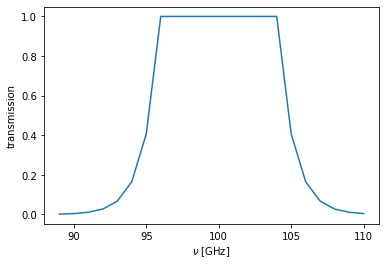

In [103]:
bandpass_parameters={
            'band_type': 'top_hat_with_exp_wings',
            'band_alpha': 0.9,
            'band_beta': 0.9,
            'band_low_edge': 96,
            'band_high_edge': 104
            }
transmission=lbs.out_of_band_analysis.bandpass_template_module.bandpass_profile(Nu,
                                        bandpass_parameters)
plt.plot(transmission[0],transmission[1])
plt.xlabel(r'$\nu$ [GHz]')
plt.ylabel('transmission')

Let's initialise Mbsparams in order to set a seed for the cmb map. The FG is always the same

In [114]:
Mbsparams = lbs.MbsParameters(
                make_cmb=True,
                make_fg=True,
                fg_models = ["pysm_synch_0", "pysm_freefree_1", "pysm_dust_0"],
                bandpass_int=True,
                maps_in_ecliptic=True,
                seed_cmb = 1234,
                nside = nside
            )

the next command will take a while with band integration, since it has to generate one map per frequency

In [115]:
hwp_sys_band.set_parameters(#maps=maps,    # ---> to use without band integration
                       integrate_in_band=True,
                       integrate_in_band_solver=True,
                       correct_in_solver=True,
                       built_map_on_the_fly=False,
                       nside=nside,
                       Mbsparams = Mbsparams,
                      Channel = channelinfo
                      )

[2022-03-23 17:05:02,894 INFO MPI#0000] using the passed instrument to generate maps
[2022-03-23 17:05:02,897 INFO MPI#0000] generating and saving cmb simulations
[2022-03-23 17:05:02,909 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2022-03-23 17:05:02,912 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-03-23 17:05:02,913 INFO MPI#0000] -> fwhm is 0.000000 arcmin
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from tutorial/cmb/0000/cmb_0000_date_220323.fits
  warnings.warn(f"Access data from {full_path}")
[2022-03-23 17:05:02,946 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2022-03-23 17:05:02,948 INFO MPI#0000] NSIDE = 64
[2022-03-23 17:05:02,949 INFO MPI#0000] ORDERING = RING in fits file
[2022-03-23 17:05:02,950 INFO MPI#0000] INDXSC

***************** D
***************** D
***************** D


/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
[2022-03-23 17:05:03,191 INFO MPI#0000] NSIDE = 512
[2022-03-23 17:05:03,192 INFO MPI#0000] ORDERING = RING in fits file
[2022-03-23 17:05:03,193 INFO MPI#0000] INDXSCHM = IMPLICIT
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
[2022-03-23 17:05:03,302 INFO MPI#0000] NSIDE = 512
[2022-03-23 17:05:03,303 INFO MPI#0000] ORDERING = RING in fits file
[2022-03-23 17:05:03,304 INFO MPI#0000] INDXSCHM = IMPLICIT
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/ff_t_new.fits (if not cach

In [116]:
t_in = time.time()
hwp_sys_band.fill_tod(obs_w,pointings,hwp_radpsec)
t_tod = time.time()
t_tod-t_in
#obs.tod *= 2.0  #this 2 factor is useful only when comparing to the mapmaking in lbs.make_bin_map
#for which the tod is twice as the one computed here

1.657311201095581

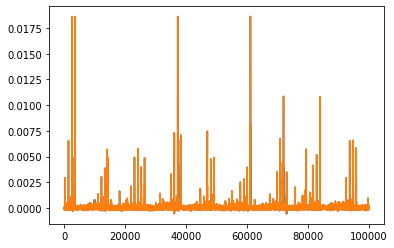

In [117]:
plt.plot(obs_w.tod[0,:100000])
plt.plot(obs_w.tod[1,:100000])

since we have few days of observation, it is pointless to generate a map

# Testing out_of_band_analysis against hwp_sys

Let's take now a top-hat band. Let's consider the actual 100 GHz one, in order to compare the result coming from out_of_band_analysis.py to the top-hat band that hwp_sys.py would consider by reading the frequencies in the parameter file `MFT_100_h_beta_z.txt`

Text(0, 0.5, 'transmission')

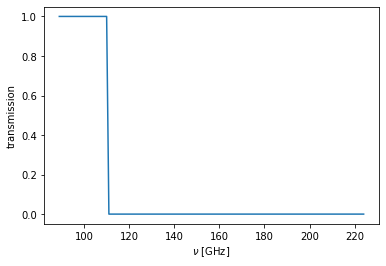

In [34]:
bandpass_parameters={
            'band_type': 'top_hat',
            'band_low_edge': Nu[0],
            'band_high_edge': Nu[-1]
            }
transmission=lbs.out_of_band_analysis.bandpass_template_module.bandpass_profile(nu,
                                        bandpass_parameters)
plt.plot(transmission[0],transmission[1])
plt.xlabel(r'$\nu$ [GHz]')
plt.ylabel('transmission')

we generate a clean observation each time we want to compute a new tod

In [11]:
obs, = sim.create_observations(detectors=dets)

In [12]:
par = { 'hwp_sys':
       {'band_filename': 'MFT_100_h_beta_z.txt',
        'band_filename_solver': 'MFT_100_h_beta_z.txt',  #same as tod parameters
        'bandpass':{
            'band_type': 'top_hat',
            'band_low_edge': Nu[0],
            'band_high_edge': Nu[-1]
            },
        'bandpass_solver':{
            'band_type': 'top_hat',
            'band_low_edge': Nu[0],
            'band_high_edge': Nu[-1]
            },
        'include_beam_throughput': False,
       }
      }

In [15]:
sim.parameter_file = par   #setting the parameter file
hwp_sys_band = lbs.HwpSysAndBandpass(sim)

In [16]:
hwp_sys_band.set_parameters(#maps=maps,    # ---> to use without band integration
                       integrate_in_band=True,
                       integrate_in_band_solver=True,
                       correct_in_solver=True,
                       built_map_on_the_fly=False,
                       nside=nside,
                       Mbsparams = Mbsparams,
                       Channel = channelinfo
                      )

[2022-03-23 16:23:20,251 INFO MPI#0000] using the passed instrument to generate maps
[2022-03-23 16:23:20,253 INFO MPI#0000] generating and saving cmb simulations
[2022-03-23 16:23:20,266 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2022-03-23 16:23:20,270 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-03-23 16:23:20,271 INFO MPI#0000] -> fwhm is 0.000000 arcmin
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from tutorial/cmb/0000/cmb_0000_date_220323.fits
  warnings.warn(f"Access data from {full_path}")
[2022-03-23 16:23:20,304 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2022-03-23 16:23:20,307 INFO MPI#0000] NSIDE = 64
[2022-03-23 16:23:20,308 INFO MPI#0000] ORDERING = RING in fits file
[2022-03-23 16:23:20,308 INFO MPI#0000] INDXSC

***************** D
***************** D
***************** D


/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
[2022-03-23 16:23:20,600 INFO MPI#0000] NSIDE = 512
[2022-03-23 16:23:20,601 INFO MPI#0000] ORDERING = RING in fits file
[2022-03-23 16:23:20,601 INFO MPI#0000] INDXSCHM = IMPLICIT
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
[2022-03-23 16:23:20,729 INFO MPI#0000] NSIDE = 512
[2022-03-23 16:23:20,729 INFO MPI#0000] ORDERING = RING in fits file
[2022-03-23 16:23:20,730 INFO MPI#0000] INDXSCHM = IMPLICIT
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/ff_t_new.fits (if not cach

In [17]:
hwp_sys_band.fill_tod(obs,pointings,hwp_radpsec)

In [18]:
obs.tod

array([[ 3.8648595e-05,  3.9065355e-05,  3.8842591e-05, ...,
         9.9393374e-06,  1.0409784e-05, -6.7875175e-05],
       [ 3.9318311e-05,  3.8736445e-05,  3.8108301e-05, ...,
         1.0193364e-05,  9.5399155e-06, -6.9180285e-05]], dtype=float32)

let's create a new simulation, initialise hwp_sys and compute the same kind of tod

In [19]:
sim1 = lbs.Simulation(base_path="./tutorial",
                     start_time=0,
                     duration_s=mission_time_is_sec,
                    )

In [20]:
mft_file = sim1.imo.query("/releases/v1.0/satellite/"+instrument+"/instrument_info")
sim1.generate_spin2ecl_quaternions(imo_url="/releases/v1.0/satellite/scanning_parameters/")

In [21]:
obs1, = sim1.create_observations(detectors=dets)

In [22]:
sim1.parameter_file = par
hwp_sys = lbs.HwpSys(sim1)

In [23]:
hwp_sys.set_parameters(#maps=maps,    # ---> to use without band integration
                       integrate_in_band=True,
                       integrate_in_band_solver = True,
                       correct_in_solver=True,
                       built_map_on_the_fly=False,
                       nside=nside,
                        Mbsparams = Mbsparams,
                      Channel = channelinfo
                      )

[2022-03-23 16:23:37,233 INFO MPI#0000] using the passed instrument to generate maps
[2022-03-23 16:23:37,237 INFO MPI#0000] generating and saving cmb simulations
[2022-03-23 16:23:37,251 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2022-03-23 16:23:37,255 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-03-23 16:23:37,256 INFO MPI#0000] -> fwhm is 0.000000 arcmin
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from tutorial/cmb/0000/cmb_0000_date_220323.fits
  warnings.warn(f"Access data from {full_path}")
[2022-03-23 16:23:37,273 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2022-03-23 16:23:37,275 INFO MPI#0000] NSIDE = 64
[2022-03-23 16:23:37,276 INFO MPI#0000] ORDERING = RING in fits file
[2022-03-23 16:23:37,277 INFO MPI#0000] INDXSC

***************** D
***************** D
***************** D


/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
[2022-03-23 16:23:37,522 INFO MPI#0000] NSIDE = 512
[2022-03-23 16:23:37,523 INFO MPI#0000] ORDERING = RING in fits file
[2022-03-23 16:23:37,523 INFO MPI#0000] INDXSCHM = IMPLICIT
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
[2022-03-23 16:23:37,635 INFO MPI#0000] NSIDE = 512
[2022-03-23 16:23:37,635 INFO MPI#0000] ORDERING = RING in fits file
[2022-03-23 16:23:37,636 INFO MPI#0000] INDXSCHM = IMPLICIT
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/ff_t_new.fits (if not cach

we see that the maps generated by the two classes are exactly the same

In [24]:
(hwp_sys.maps == hwp_sys_band.maps).all()

True

In [25]:
hwp_sys.fill_tod(obs1,pointings,hwp_radpsec)

The bands are the same

In [26]:
hwp_sys.cmb2bb/hwp_sys.norm == hwp_sys_band.cmb2bb

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [27]:
obs1.tod - obs.tod

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [29]:
(obs.tod == obs1.tod).all()

True

the two tod are exactly the same when we set `include_beam_throughput=False` in `hwp_sys_band.set_parameters`

## Introducing a shift to the bands

We can set the steps for generating tods including bands that have some shifts (we can both set a rigid shift of the two ends of the band and shift them differently).

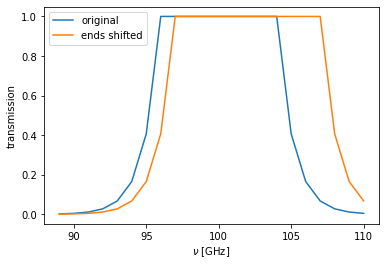

In [36]:
shift_low = 1  #needed resolution of 1 GHz since this is the present resolution on HWP parameters
shift_high = 3
bandpass_parameters={
            'band_type': 'top_hat_with_exp_wings',
            'band_alpha': 0.9,
            'band_beta': 0.9,
            'band_low_edge': 96,
            'band_high_edge': 104
            }
bandpass_parameters_sh={
            'band_type': 'top_hat_with_exp_wings',
            'band_alpha': 0.9,
            'band_beta': 0.9,
            'band_low_edge': 96+shift_low,
            'band_high_edge': 104+shift_high
            }
transmission=lbs.out_of_band_analysis.bandpass_template_module.bandpass_profile(Nu,
                                        bandpass_parameters)
transmission_shifted=lbs.out_of_band_analysis.bandpass_template_module.bandpass_profile(Nu,
                                        bandpass_parameters_sh)
plt.plot(transmission[0],transmission[1],label = 'original')
plt.plot(transmission_shifted[0],transmission_shifted[1],label = 'ends shifted')
plt.xlabel(r'$\nu$ [GHz]')
plt.ylabel('transmission')
plt.legend()

In [125]:
par = { 'hwp_sys':
       {'band_filename': 'MFT_100_h_beta_z.txt',
        'band_filename_solver': 'MFT_100_h_beta_z.txt',  #same as tod parameters
        'bandpass':{
            'band_type': 'top_hat_with_exp_wings',
            'band_alpha': 0.9,
            'band_beta': 0.9,
            'band_low_edge': 96,
            'band_high_edge': 104,
            },
        'bandpass_solver':{
            'band_type': 'top_hat_with_exp_wings',
            'band_alpha': 0.9,
            'band_beta': 0.9,
            'band_low_edge': 96+shift_low,
            'band_high_edge': 104+shift_high,
            },
        'include_beam_throughput': True,
       }
      }

In [126]:
obs_sh, = sim.create_observations(detectors=dets)
sim.parameter_file = par   #setting the parameter file
hwp_sys_band = lbs.HwpSysAndBandpass(sim)

In [127]:
hwp_sys_band.set_parameters(#maps=maps,    # ---> to use without band integration
                       integrate_in_band=True,
                       integrate_in_band_solver = True,
                       correct_in_solver=True,
                       built_map_on_the_fly=False,
                       nside=nside,
                       Mbsparams = Mbsparams,
                       Channel=channelinfo
                      )

[2022-03-23 17:06:11,611 INFO MPI#0000] using the passed instrument to generate maps
[2022-03-23 17:06:11,614 INFO MPI#0000] generating and saving cmb simulations
[2022-03-23 17:06:11,626 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2022-03-23 17:06:11,630 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-03-23 17:06:11,630 INFO MPI#0000] -> fwhm is 0.000000 arcmin
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from tutorial/cmb/0000/cmb_0000_date_220323.fits
  warnings.warn(f"Access data from {full_path}")
[2022-03-23 17:06:11,701 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2022-03-23 17:06:11,704 INFO MPI#0000] NSIDE = 64
[2022-03-23 17:06:11,704 INFO MPI#0000] ORDERING = RING in fits file
[2022-03-23 17:06:11,705 INFO MPI#0000] INDXSC

***************** D
***************** D
***************** D


/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
[2022-03-23 17:06:11,940 INFO MPI#0000] NSIDE = 512
[2022-03-23 17:06:11,941 INFO MPI#0000] ORDERING = RING in fits file
[2022-03-23 17:06:11,941 INFO MPI#0000] INDXSCHM = IMPLICIT
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
[2022-03-23 17:06:12,049 INFO MPI#0000] NSIDE = 512
[2022-03-23 17:06:12,049 INFO MPI#0000] ORDERING = RING in fits file
[2022-03-23 17:06:12,050 INFO MPI#0000] INDXSCHM = IMPLICIT
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/ff_t_new.fits (if not cach

In [128]:
hwp_sys_band.fill_tod(obs_sh,pointings,hwp_radpsec)

let's compare the tod produced with shifts to the 'normal' one

Text(0, 0.5, 'tod w/ shifts - tod w/o shifts')

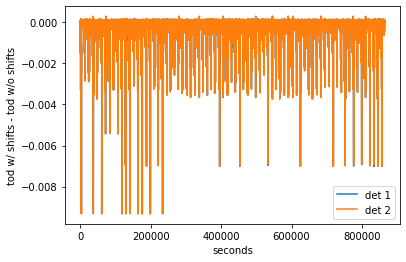

In [129]:
plt.plot(obs_sh.tod[0]-obs_w.tod[0], label = 'det 1')
plt.plot(obs_sh.tod[1]-obs_w.tod[1], label = 'det 2')
plt.legend()
plt.xlabel('seconds')
plt.ylabel('tod w/ shifts - tod w/o shifts')

There is overall a ~ percent difference between the two. The difference is due to the foregrounds, which are frequency dependent, and the interplay with chromatic HWP non-idealities

## To make a map

In [42]:
obs, = sim.create_observations(detectors=dets)

pointings = lbs.scanning.get_pointings(obs,
                                       spin2ecliptic_quats=sim.spin2ecliptic_quats,
                                       detector_quats=detquats,
                                       bore2spin_quat=instrumentinfo.bore2spin_quat,
                                      )

In [43]:
par = { 'hwp_sys':
       {'band_filename': 'MFT_100_h_beta_z.txt',
        'band_filename_solver': 'MFT_100_h_beta_z.txt',  #same as tod parameters
        'bandpass':{
            'band_type': 'top_hat_with_exp_wings',
            'band_alpha': 0.9,
            'band_beta': 0.9,
            'band_low_edge': 96,
            'band_high_edge': 104,
            },
        'bandpass_solver':{
            'band_type': 'top_hat_with_exp_wings',
            'band_alpha': 0.9,
            'band_beta': 0.9,
            'band_low_edge': 96,
            'band_high_edge': 104,
            },
        'include_beam_throughput': True,
       }
      }

In [44]:
sim.parameter_file = par   #setting the parameter file
hwp_sys_band = lbs.HwpSysAndBandpass(sim)

In [45]:
hwp_sys_band.set_parameters(#maps=maps,    # ---> to use without band integration
                       integrate_in_band=True,
                       correct_in_solver=True,
                       integrate_in_band_solver = True,
                       built_map_on_the_fly=True,
                       nside=nside,
                       Mbsparams = Mbsparams,
                      Channel = channelinfo
                      )

[2022-03-23 16:31:18,922 INFO MPI#0000] using the passed instrument to generate maps
[2022-03-23 16:31:18,925 INFO MPI#0000] generating and saving cmb simulations
[2022-03-23 16:31:18,941 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-03-23 16:31:18,941 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-03-23 16:31:18,960 INFO MPI#0000] NSIDE = 64
[2022-03-23 16:31:18,960 INFO MPI#0000] ORDERING = RING in fits file
[2022-03-23 16:31:18,961 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-03-23 16:31:19,077 INFO MPI#0000] generating and saving fg simulations
[2022-03-23 16:31:19,080 INFO MPI#0000] NSIDE = 512
[2022-03-23 16:31:19,081 INFO MPI#0000] ORDERING = RING in fits file
[2022-03-23 16:31:19,082 INFO MPI#0000] INDXSCHM = IMPLICIT


***************** D
***************** D
***************** D


[2022-03-23 16:31:19,209 INFO MPI#0000] NSIDE = 512
[2022-03-23 16:31:19,209 INFO MPI#0000] ORDERING = RING in fits file
[2022-03-23 16:31:19,210 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-03-23 16:31:19,317 INFO MPI#0000] NSIDE = 512
[2022-03-23 16:31:19,318 INFO MPI#0000] ORDERING = RING in fits file
[2022-03-23 16:31:19,318 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-03-23 16:31:20,688 INFO MPI#0000] NSIDE = 512
[2022-03-23 16:31:20,689 INFO MPI#0000] ORDERING = RING in fits file
[2022-03-23 16:31:20,698 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-03-23 16:31:20,859 INFO MPI#0000] NSIDE = 512
[2022-03-23 16:31:20,860 INFO MPI#0000] ORDERING = RING in fits file
[2022-03-23 16:31:20,862 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-03-23 16:31:20,966 INFO MPI#0000] NSIDE = 512
[2022-03-23 16:31:20,967 INFO MPI#0000] ORDERING = RING in fits file
[2022-03-23 16:31:20,967 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-03-23 16:31:21,066 INFO MPI#0000] NSIDE = 512
[2022-03-23 16:31:21,067 INFO MPI#0000] ORD

In [46]:
hwp_sys_band.fill_tod(obs,pointings,hwp_radpsec)

In [47]:
maps = hwp_sys_band.make_map([obs])

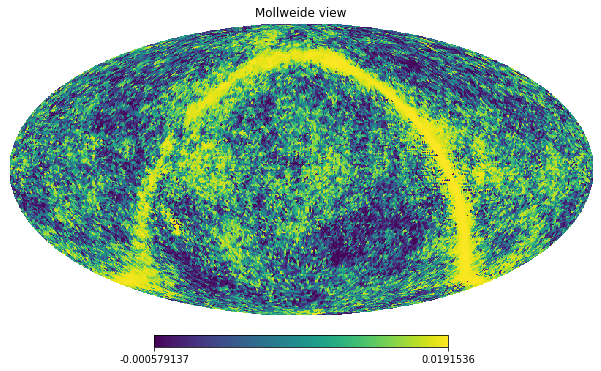

In [48]:
hp.mollview(maps[0], norm = 'hist')

let's try to subtract to that the input maps, integrated in band like the tod:

In [49]:
int_maps = np.zeros_like(hwp_sys_band.maps)
for i in range(int_maps.shape[0]):
    int_maps[i] = hwp_sys_band.cmb2bb[i]*hwp_sys_band.maps[i]

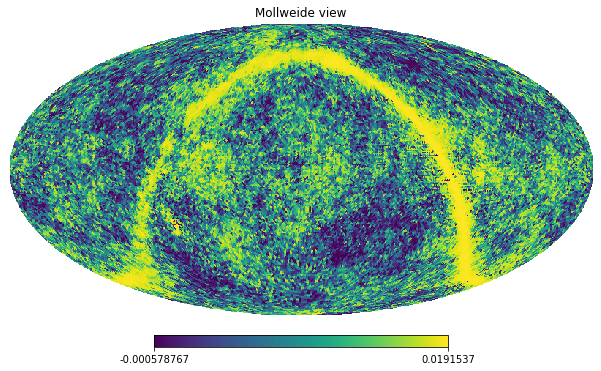

In [50]:
summed_maps = int_maps.sum(axis = 0)
hp.mollview(summed_maps[0], norm = 'hist')

The difference between the output and the integral in frequency of band * input map is not null because of the chromaticity of FG and HWP+bandpass parameters coupled to the mapmaking procedure. The CMB contribution is perfectly canceled out

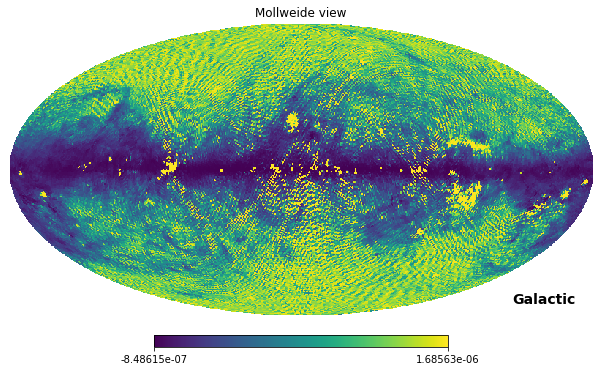

In [51]:
hp.mollview(maps[0]-summed_maps[0], norm = 'hist', coord = ['E','G'])

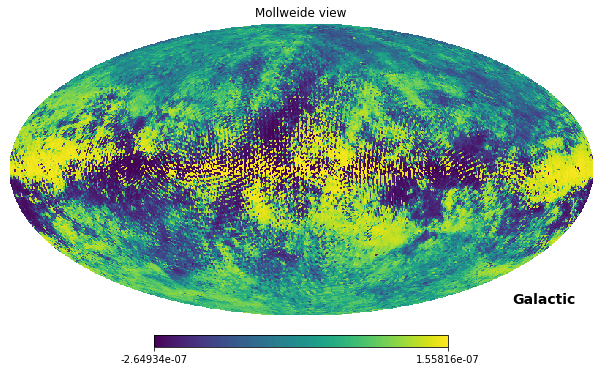

In [52]:
hp.mollview(maps[1]-summed_maps[1], norm = 'hist',coord = ['E','G'])

let's consider now a mismatch in the band between tod and solver:

In [53]:
par = { 'hwp_sys':
       {'band_filename': 'MFT_100_h_beta_z.txt',
        'band_filename_solver': 'MFT_100_h_beta_z.txt',  #same as tod parameters
        'bandpass':{
            'band_type': 'top_hat_with_exp_wings',
            'band_alpha': 0.9,
            'band_beta': 0.9,
            'band_low_edge': 96,
            'band_high_edge': 104,
            },
        'bandpass_solver':{
            'band_type': 'top_hat',
            'band_low_edge': 96,
            'band_high_edge': 104,
            },
        'include_beam_throughput': True,
       }
      }

In [54]:
sim.parameter_file = par   #setting the parameter file
hwp_sys_band = lbs.HwpSysAndBandpass(sim)

In [55]:
hwp_sys_band.set_parameters(#maps=maps,    # ---> to use without band integration
                       integrate_in_band=True,
                       correct_in_solver=True,
                       integrate_in_band_solver = True,
                       built_map_on_the_fly=True,
                       nside=nside,
                       Mbsparams = Mbsparams,
                       Channel = channelinfo
                      )

[2022-03-23 16:44:17,763 INFO MPI#0000] using the passed instrument to generate maps
[2022-03-23 16:44:17,767 INFO MPI#0000] generating and saving cmb simulations
[2022-03-23 16:44:17,779 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2022-03-23 16:44:17,783 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-03-23 16:44:17,783 INFO MPI#0000] -> fwhm is 0.000000 arcmin
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from tutorial/cmb/0000/cmb_0000_date_220323.fits
  warnings.warn(f"Access data from {full_path}")
[2022-03-23 16:44:17,798 WARNING MPI#0000] AstropyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
[2022-03-23 16:44:17,803 INFO MPI#0000] NSIDE = 64
[2022-03-23 16:44:17,803 INFO MPI#0000] ORDERING = RING in fits file
[2022-03-23 16:44:17,803 INFO MPI#0000] INDXSC

***************** D
***************** D
***************** D


/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
[2022-03-23 16:44:18,063 INFO MPI#0000] NSIDE = 512
[2022-03-23 16:44:18,064 INFO MPI#0000] ORDERING = RING in fits file
[2022-03-23 16:44:18,065 INFO MPI#0000] INDXSCHM = IMPLICIT
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
[2022-03-23 16:44:18,184 INFO MPI#0000] NSIDE = 512
[2022-03-23 16:44:18,185 INFO MPI#0000] ORDERING = RING in fits file
[2022-03-23 16:44:18,185 INFO MPI#0000] INDXSCHM = IMPLICIT
/home/sgiardie/anaconda3/envs/lbs_env/lib/python3.8/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/ff_t_new.fits (if not cach

In [56]:
hwp_sys_band.fill_tod(obs,pointings,hwp_radpsec)

In [57]:
maps_mism = hwp_sys_band.make_map([obs])

In [61]:
int_maps_solver = np.zeros_like(hwp_sys_band.maps)
for i in range(int_maps.shape[0]):
    int_maps_solver = hwp_sys_band.cmb2bb_solver[i]*hwp_sys_band.maps[i]
summed_maps_solver = int_maps_solver.sum(axis = 0)

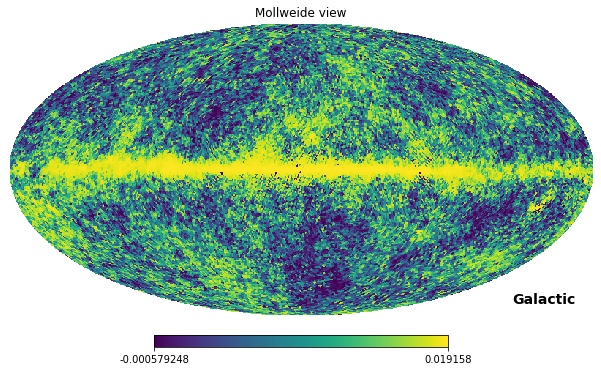

In [62]:
hp.mollview(maps_mism[0]-summed_maps_solver[0], norm = 'hist', coord = ['E','G'])

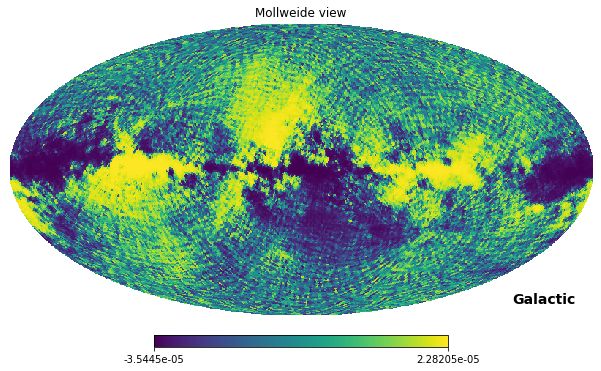

In [63]:
hp.mollview(maps_mism[1]-summed_maps_solver[1], norm = 'hist', coord = ['E','G'])

we see that we have a residual of CMB in those maps, due to the bandpass mismatch. Let's try and derive the spectra of those residual maps

In [64]:
res_nomism = maps-summed_maps
res_mism = maps_mism-summed_maps_solver

In [74]:
cl_nomism = hp.anafast(res_nomism)*1e12
cl_mism = hp.anafast(res_mism)*1e12
ell = np.arange(cl_mism.shape[1])

Text(0.5, 1.0, 'Power spectra of residuals')

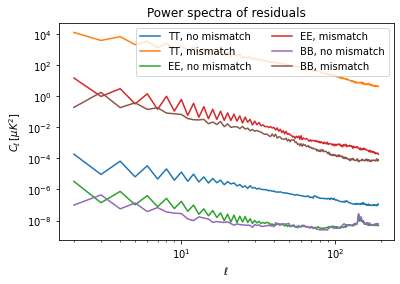

In [75]:
plt.loglog(ell[2:],cl_nomism[0,2:],label = 'TT, no mismatch')
plt.loglog(ell[2:],cl_mism[0,2:],label = 'TT, mismatch')
plt.loglog(ell[2:],cl_nomism[1,2:],label = 'EE, no mismatch')
plt.loglog(ell[2:],cl_mism[1,2:],label = 'EE, mismatch')
plt.loglog(ell[2:],cl_nomism[2,2:],label = 'BB, no mismatch')
plt.loglog(ell[2:],cl_mism[2,2:],label = 'BB, mismatch')
plt.legend(ncol = 2, loc = 'upper right')
plt.ylabel(r'$C_{\ell} \, [\mu K^2]$')
plt.xlabel('$\ell$')
plt.title('Power spectra of residuals')

The residual maps are not masked so the main contribution in all cases comes from the galactic plane